# Comments start in the 'Cosmic Dispersion' section

# Load Modules

In [29]:
%matplotlib notebook
import pickle
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
import matplotlib.patches as mpatches
from astropy.io.votable import parse
from astropy.table import vstack
from matplotlib.collections import LineCollection
from matplotlib.ticker import FuncFormatter
from numpy import log10 as log
from numpy import log as ln
def scientific_notation(x, pos):return "${:.1e}$".format(x).replace("e+0","e")
from UCDs_workspace import his,bar,bar_car


# Load DR3 & filtering results

In [2]:
cns=parse('cns.vot').resources[0].tables[0].to_table()

try:ta1,ta2
except:
    ta1=parse('ucd.vot').resources[0].tables[0].to_table()
    ta2=parse('car.vot').resources[0].tables[0].to_table()
tab=vstack([ta1,ta2])

ruw=dict(zip(tab['source_id'],tab['ruwe']))
grp=dict(zip(tab['source_id'],tab['g_rp']))
rpm=dict(zip(tab['source_id'],tab['phot_rp_mean_mag']))
gmm=dict(zip(tab['source_id'],tab['phot_g_mean_mag']))
par=dict(zip(tab['source_id'],tab['parallax']))
p_e=dict(zip(tab['source_id'],tab['parallax_error']))

dr3={'grp':grp,'rpm':rpm,'par':par,'par_err':p_e,'gmm':gmm,'ruw':ruw}

with open('dic.pickle','rb') as f:dic=pickle.load(f)
with open('spe.pickle','rb') as f:spe_55,err_55=pickle.load(f)

ta2=parse('viz.vot').resources[0].tables[0].to_table()
ids=list(ta2['dr2_source_id'].data.data)
car=len(ids)
with open('ext.pickle','rb')as f:ext=pickle.load(f)

# CAMD

<IPython.core.display.Javascript object>


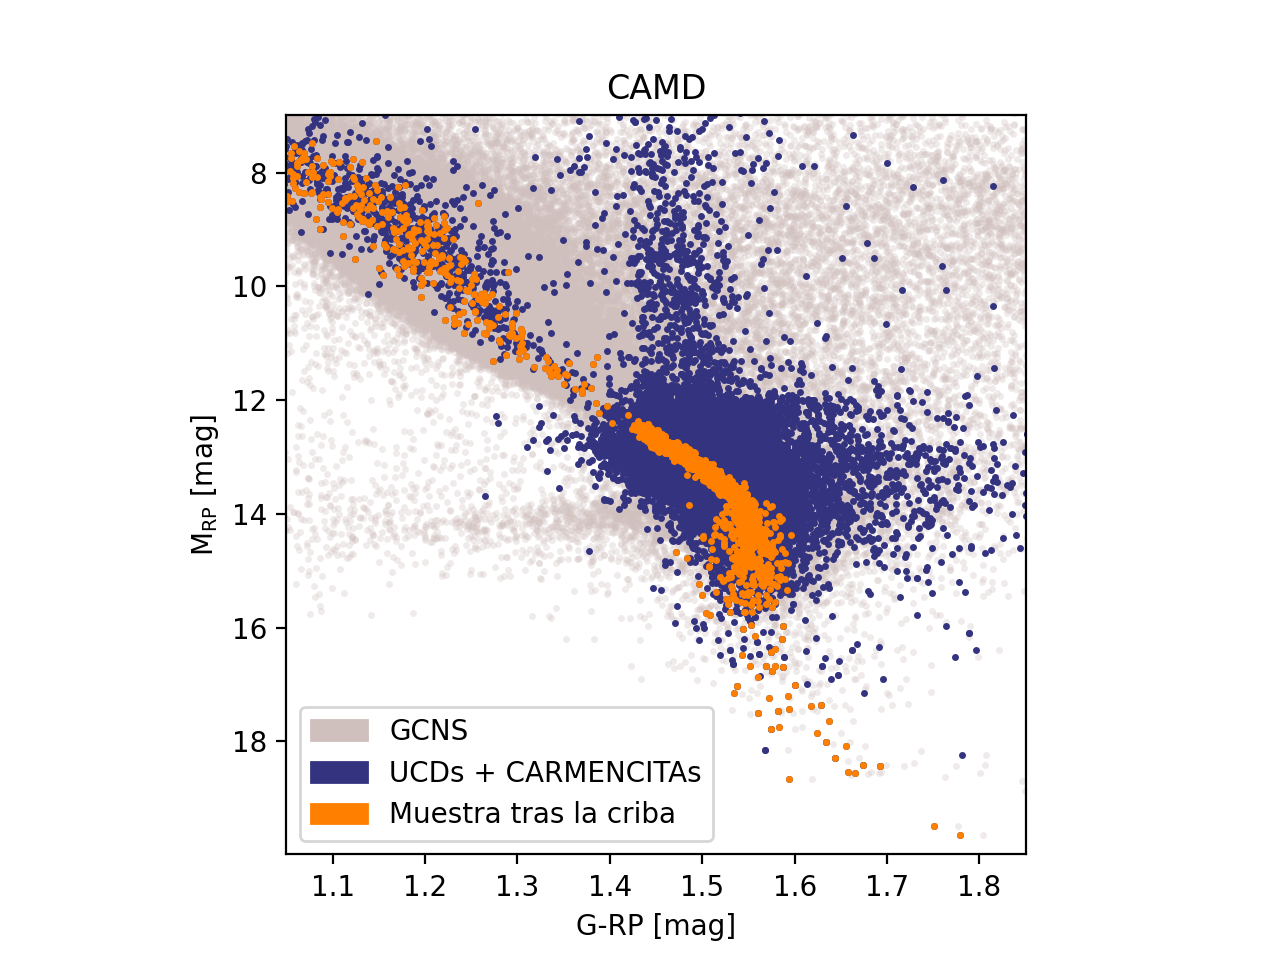

In [3]:
fig,ax=plt.subplots()
yax=cns['phot_rp_mean_mag'].data.data-10+5*log(cns['parallax'].data.data)
plt.plot(cns['g_rp'].data.data,yax,'o',alpha=.3,markeredgewidth=0,markersize=2.5,color='#d0c0bd', zorder=0)
yax=tab['phot_rp_mean_mag'].data.data-10+5*log(tab['parallax'].data.data)
plt.plot(tab['g_rp'].data.data,yax,'o',markeredgewidth=0,markersize=2.5,color='#333380')
dat=[(dr3['grp'][id_],dr3['rpm'][id_]-10+5*log(dr3['par'][id_]))for typ in dic if dic[typ]is not None for id_ in dic[typ]]
plt.plot([sou[0]for sou in dat],[sou[1]for sou in dat],'o',markeredgewidth=0,markersize=2.5,color='#ff8000')
plt.title('CAMD');plt.xlabel('G-RP [mag]');plt.ylabel(r'M$_{\rm RP}$ [mag]')
ax.set_xlim(1.05,1.85);ax.set_ylim(19.99,6.99);ax.set_aspect(1.0/ax.get_data_ratio(),adjustable='box')
a=mpatches.Patch(color='#d0c0bd',label='GCNS')
b=mpatches.Patch(color='#333380',label='UCDs + CARMENCITAs')
c=mpatches.Patch(color='#ff8000',label='Muestra tras la criba')
plt.legend(handles=[a,b,c])
plt.show()


# Median(Filtered) = Base

<IPython.core.display.Javascript object>


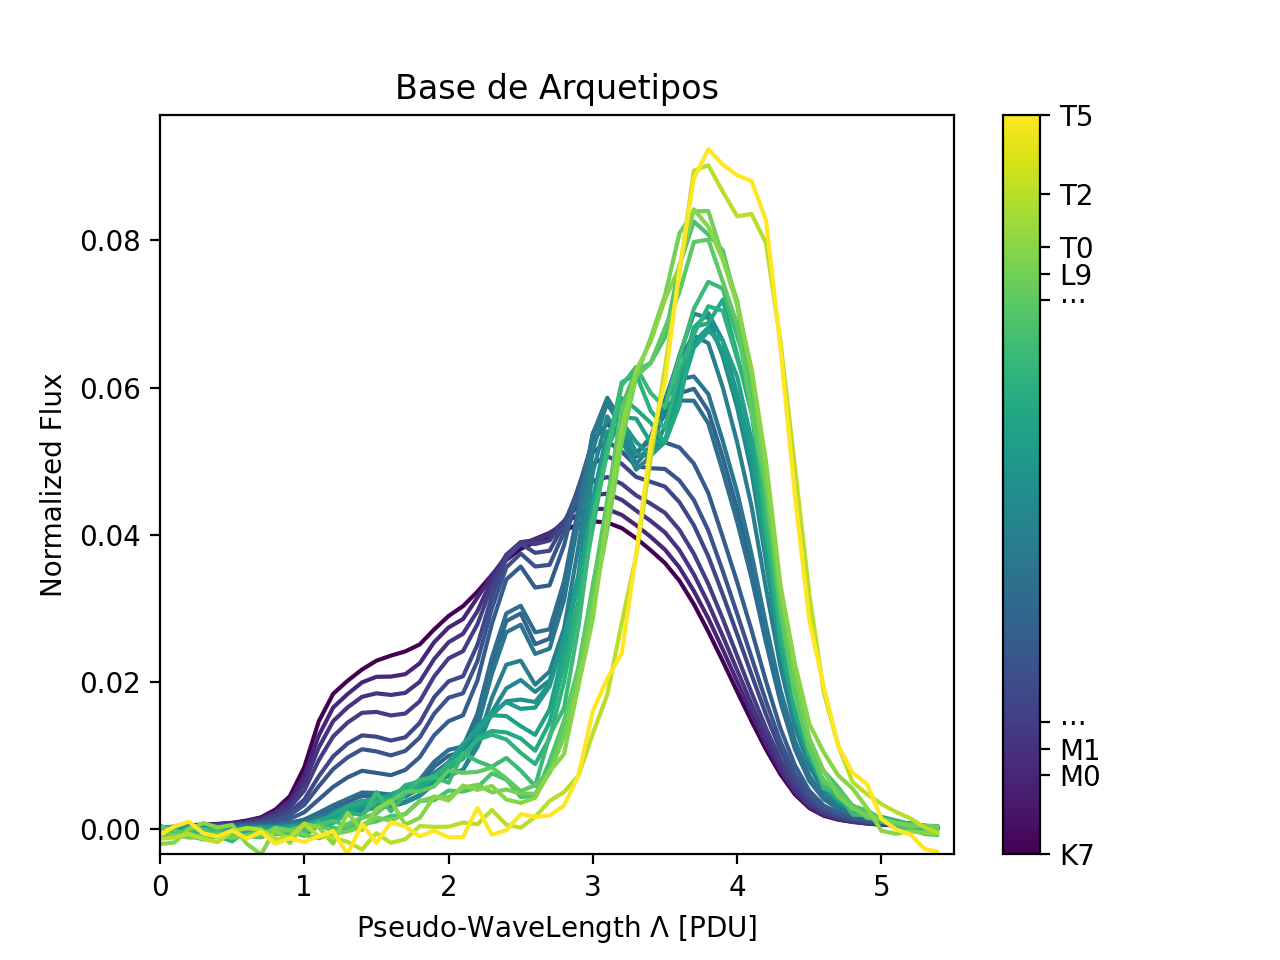

In [4]:
fig,ax=plt.subplots()
xax=0.1*np.array(range(len(spe_55[list(spe_55.keys())[0]])))
bas={typ:np.median([spe_55[id_]*1e4/par[id_]**2 for id_ in dic[typ]],axis=0)for typ in dic if dic[typ]is not None}
yxs=[bas[typ]/sum(bas[typ])for typ in bas]
line_segments=LineCollection([np.column_stack([xax,yax])for yax in yxs],array=[ind for ind,typ in enumerate(dic.keys())if dic[typ]is not None])
ax.add_collection(line_segments)
axcb=fig.colorbar(line_segments,ticks=[0,3,4,5,21,22,23,25,28])
axcb.ax.set_yticklabels(['K7','M0','M1','···','···','L9','T0','T2','T5']) 
ax.set_title('Base de Arquetipos')
plt.xlabel(r'Pseudo-WaveLength $\Lambda$ [PDU]');plt.ylabel('Normalized Flux')
ax.set_xlim(0,5.5);ax.set_ylim(np.min(yxs),np.max(yxs)*1.05)
plt.show()


# Cosmic Dispersion

Vamos a estudiar la dispersión cósmica. Para cada tipo espectral 'typ' y para cada pseudo- longitud de onda 'lmd', leeré el flujo a esa 'lmd' de todos los espectros que superaron la criba de calidad y están clasificados en ese 'typ', y calcularé la desviación estandar 'std' de los mismos. Cuando para un 'typ' tenga una función de 'std' en función de 'lmd', 'std(lmb)', calculare el factor de escala 'fac' que escale el espectro mediana de ese 'typ' a esta función, i.e. ∫std = ∫typ*fac Todo esto será útil en la celda siguiente.

<IPython.core.display.Javascript object>


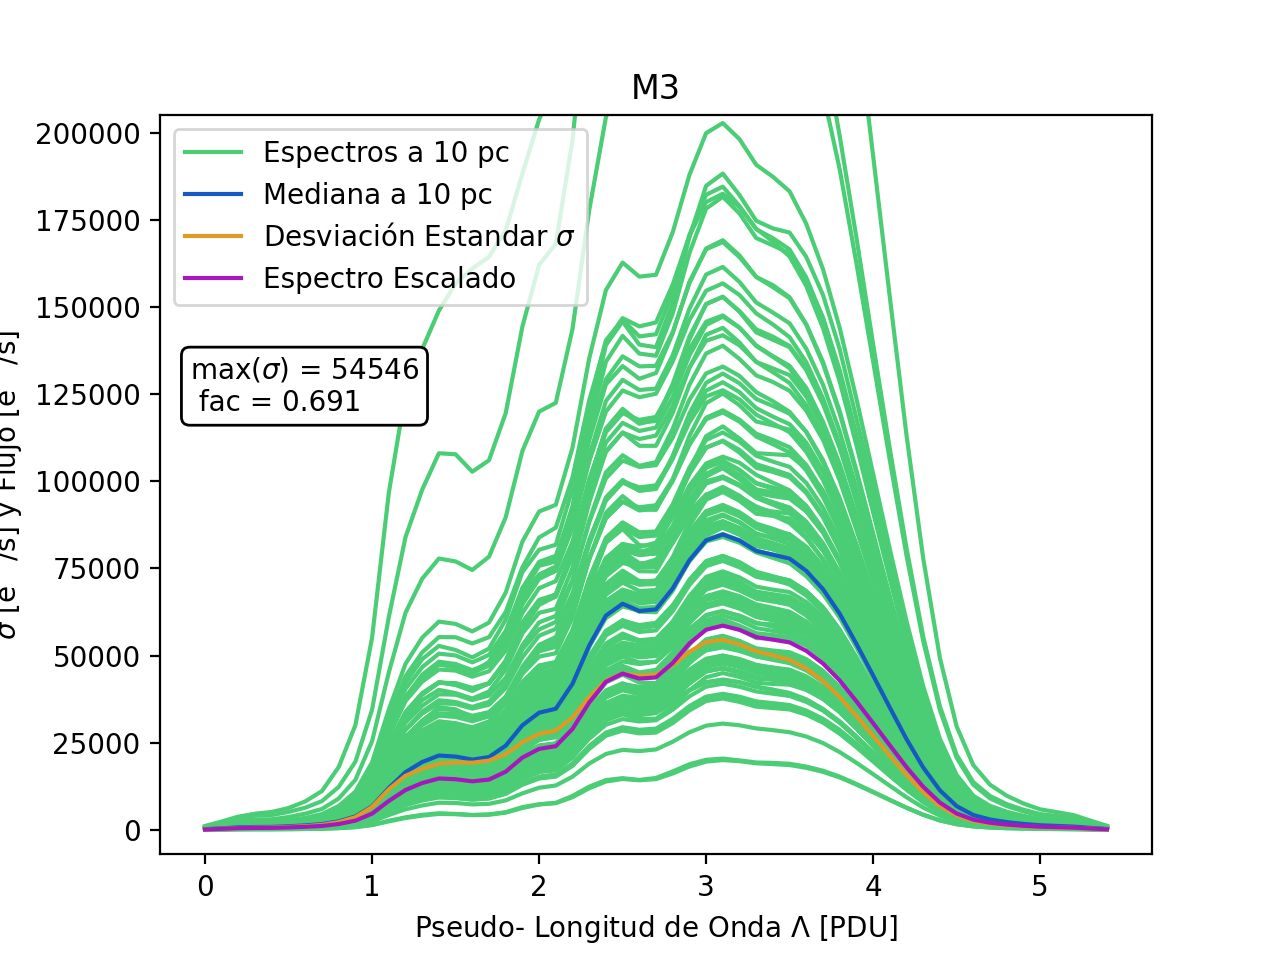

<IPython.core.display.Javascript object>


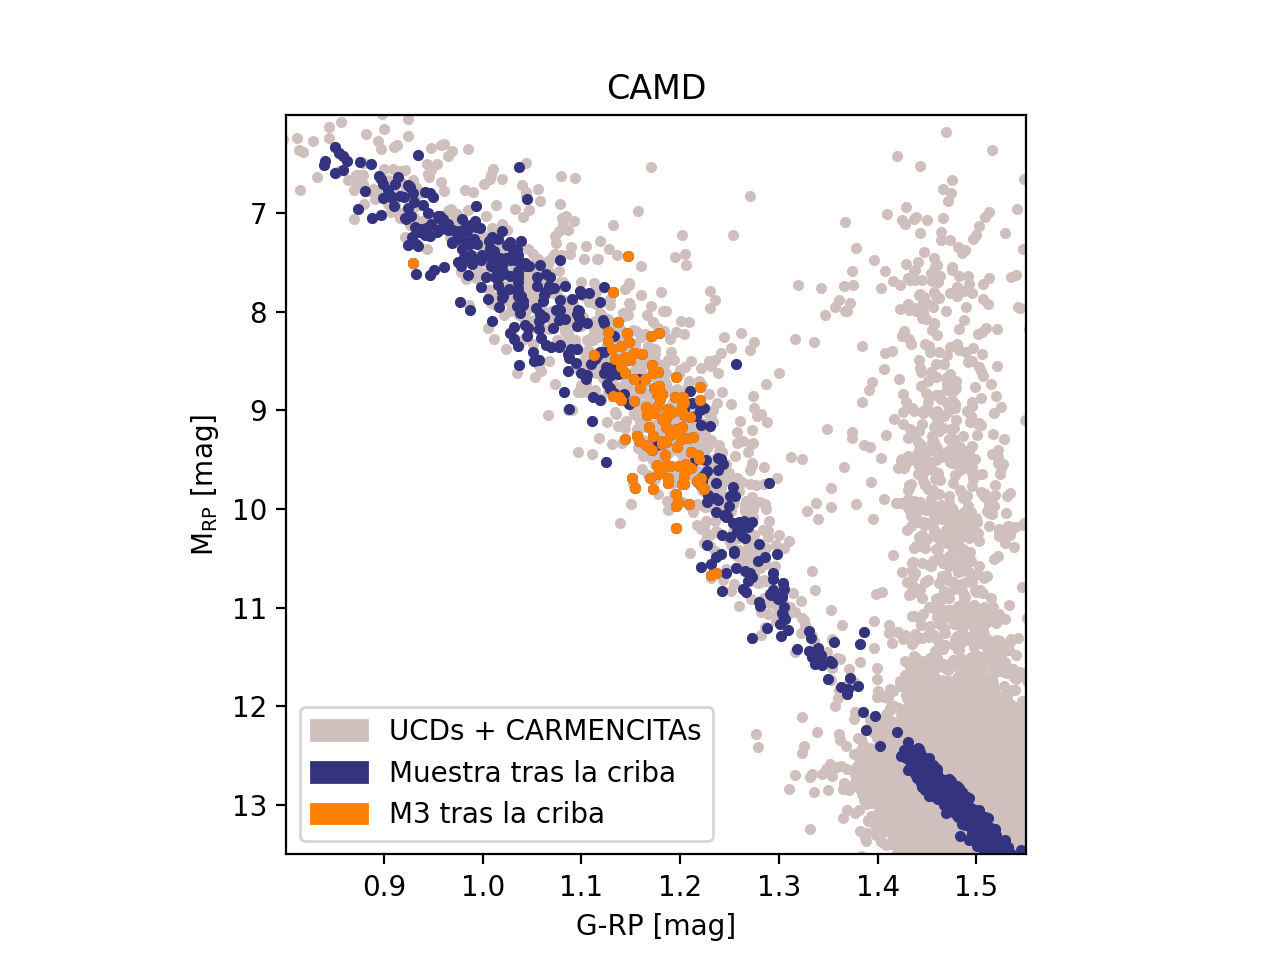

<IPython.core.display.Javascript object>


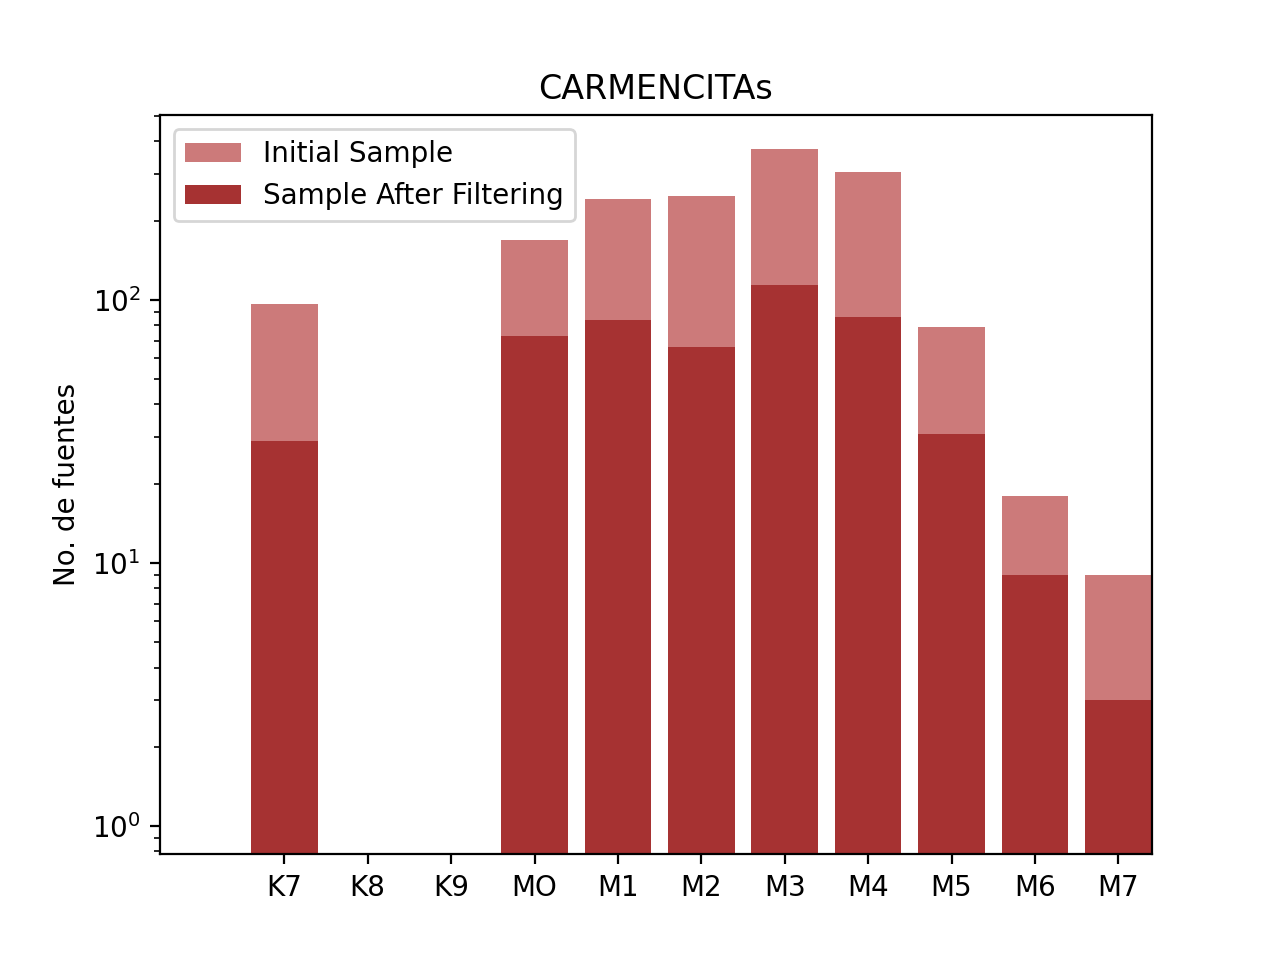

In [104]:
# Guardaré las desviadiones estandar en 'std'
std={}

# Guardaré los factores de escala en 'fac'
fac={}

# Itero para cada tipo espectral 'typ'
for typ in bas:
    if typ!='None':

        # Los 'typ' serán las key en el dict. 'std'
        std[typ]=[]

        # Itero para cada pseudo- longitud de onda 'lmd'
        for lmb in range(55):

            # Guardaré en 'dat' los flujos de todos los espectros de este 'typ' para esta 'lmd'
            dat=[]

            # Itero para cada espectro RP leyendo su ID 'id_'
            for id_ in dic[typ]:

                # Leo el flujo
                flx=spe_55[id_][lmb]

                # Leo la paralaje
                par=dr3['par'][id_]

                # Corrijo el flujo en distancia (dejándolo a 10 pc)
                # 'par' está en m.a.s. Pasarlo a arc.sec implica un factor 1e-3, pero como está ^-2, es 1e6
                # Para de dejarlo a 10 pc, como la paralaje va ^-2, el factor es 1e-2
                # En conjunto, tenemos un factor 1e4
                flx=flx*1e4/par**2

                # Guardo el resultado en dat
                dat.append(flx)

            # Calculo la desviación estandar de 'dat'
            std_lmd=np.std(dat)

            # Guardo el resultado en std[typ]
            std[typ].append(std_lmd)

        # ∫std = np.sum(std[typ]) sería el area (suma de valores) de la función 'std' en función de 'lmb'
        # ∫typ*fac = fac*np.sum(bas[typ]) sería la del espectro mediana de este 'typ' escalado por 'fac'
        # Aquí calculo el factor de escala 'fac' que escale el espectro mediana de este 'typ' a std(lmd)
        # Para ello igualo areas ∫std = ∫typ*fac y llego a
        fac[typ]=np.sum(std[typ])/np.sum(bas[typ])

        #
        # Plots
        #

        if typ=='M3':
            fig,ax=plt.subplots()
            for id_ in dic[typ]:ax.plot(xax,spe_55[id_]*1e4/dr3['par'][id_]**2,color='#4bcd76')
            ax.plot(xax,spe_55[id_]*1e4/dr3['par'][id_]**2,color='#4bcd76',label='Espectros a 10 pc')
            ax.plot(xax,bas[typ],label='Mediana a 10 pc',color='#155ac2')
            plt.plot(xax,std[typ],color='#de9a24',label=r'Desviación Estandar $\sigma$')
            plt.plot(xax,bas[typ]*fac[typ],color='#a817be',label='Espectro Escalado')
            plt.xlabel(r'Pseudo- Longitud de Onda $\Lambda$ [PDU]');plt.ylabel(r'Flujo a 10 pc [e$^-$/s]')
            plt.ylabel(r'$\sigma$ [e$^-$/s] y Flujo [e$^-$/s]')
            plt.ylim(-7e3,2.05e5)
            ax.text(.03,.6,r'max($\sigma$) = '+str(int(max(std[typ])))+'\n fac = '+str(int(1000*fac[typ])/1000),transform=ax.transAxes,bbox=dict(boxstyle='round',facecolor='white'))
            ax.set_title(typ);plt.legend();plt.show()
        if typ=='M3':
            fig,ax=plt.subplots()
            #yax=cns['phot_rp_mean_mag'].data.data-10+5*log(cns['parallax'].data.data)
            #plt.plot(cns['g_rp'].data.data,yax,'o',alpha=.3,markeredgewidth=0,markersize=2.5,color='#d0c0bd', zorder=0)
            yax=tab['phot_rp_mean_mag'].data.data-10+5*log(tab['parallax'].data.data)
            plt.plot(tab['g_rp'].data.data,yax,'o',markeredgewidth=0,markersize=4,color='#d0c0bd')
            dat=[(dr3['grp'][id_],dr3['rpm'][id_]-10+5*log(dr3['par'][id_]))for typ in dic if dic[typ]is not None for id_ in dic[typ]]
            plt.plot([sou[0]for sou in dat],[sou[1]for sou in dat],'o',markeredgewidth=0,markersize=4,color='#333380')
            dat=[(dr3['grp'][id_],dr3['rpm'][id_]-10+5*log(dr3['par'][id_])) for id_ in dic[typ]]
            plt.plot([sou[0]for sou in dat],[sou[1]for sou in dat],'o',markeredgewidth=0,markersize=4,color='#ff8000')
            plt.title('CAMD');plt.xlabel('G-RP [mag]');plt.ylabel(r'M$_{\rm RP}$ [mag]')
            ax.set_xlim(.801,1.55);ax.set_ylim(13.5,6.01);ax.set_aspect(1.0/ax.get_data_ratio(),adjustable='box')
            a=mpatches.Patch(color='#d0c0bd',label='UCDs + CARMENCITAs')
            b=mpatches.Patch(color='#333380',label='Muestra tras la criba')
            c=mpatches.Patch(color='#ff8000',label=typ+' tras la criba')
            plt.legend(handles=[a,b,c])
            plt.show()
        if False:#typ=='M7':
            fig,ax=plt.subplots()
            plt.plot(xax,std[typ],color='#ff004e',label=r'Desviación Estandar $\sigma$')
            plt.plot(xax,bas[typ]*fac[typ],color='#293e9d',label='Espectro Escalado')
            plt.xlabel(r'Pseudo- Longitud de Onda $\Lambda$ [PDU]')
            plt.ylabel(r'$\sigma$ [e$^-$/s] y Flujo [e$^-$/s]')
            ax.set_title('Dispersión para '+typ)
            plt.legend();plt.show()
if True:
    xti_lim=.3;nss_lim=.04;ntr_lim=23;nme_lim=1340;foe_lim=50;per_lim=4.4;aen_lim=3;ruw_lim=1.3;pax_lim=20;poe_lim=45
    fil_new_car=[(id3,id2) for pax,p_e,id3,nss,var,ntr,nme,foe,fla,ble,con,tmg,aen,ruw,xti,per,id2 in zip(
        ta2['parallax'],ta2['parallax_over_error'],ta2['source_id'],
        ta2['ipd_gof_harmonic_amplitude'],ta2['phot_variable_flag'],ta2['rp_n_transits'],ta2['rp_n_measurements'],
        ta2['phot_rp_mean_flux_over_error'],ta2['flags_espucd'],ta2['rp_n_blended_transits'],
        ta2['rp_n_contaminated_transits'],ta2['ipd_frac_odd_win'],ta2['astrometric_excess_noise'],ta2['ruwe'],
        ext,ta2['rp_n_blended_transits']/ta2['rp_n_transits']*100,ids)if p_e>poe_lim and pax>pax_lim and 
         nss<=nss_lim and var!='VARIABLE'and ntr>=ntr_lim and nme>=nme_lim and foe>=foe_lim and
            per<=per_lim and con==0 and tmg==0 and aen<=aen_lim and ruw<=ruw_lim and xti<=xti_lim]
    bar_car([[list(ta2['dr2_source_id'].data.data),'Initial Sample','#cc7a7a'],
             [[itm[1]for itm in fil_new_car],'Sample After Filtering','#a63232']],'CARMENCITAs')


The Standard Deviation 'std[typ]' due to cosmic dispersion is defined for each 'typ' as follows: For those 'typ' for which more than one spectra were found in DR3, the cell above has calculated a valid 'std(lmb)' function and we keep that result. For those 'typ' for which only one spectrum was found, the cell above returned 'std(lmb)=0'. We now replace those non-acceptable 'std(lmb)' funtions with a new std function estimated as the spectrum classified as that 'typ' escalated by a factor which we take as the median of all 'fac' calculated by the previous cell.

<IPython.core.display.Javascript object>


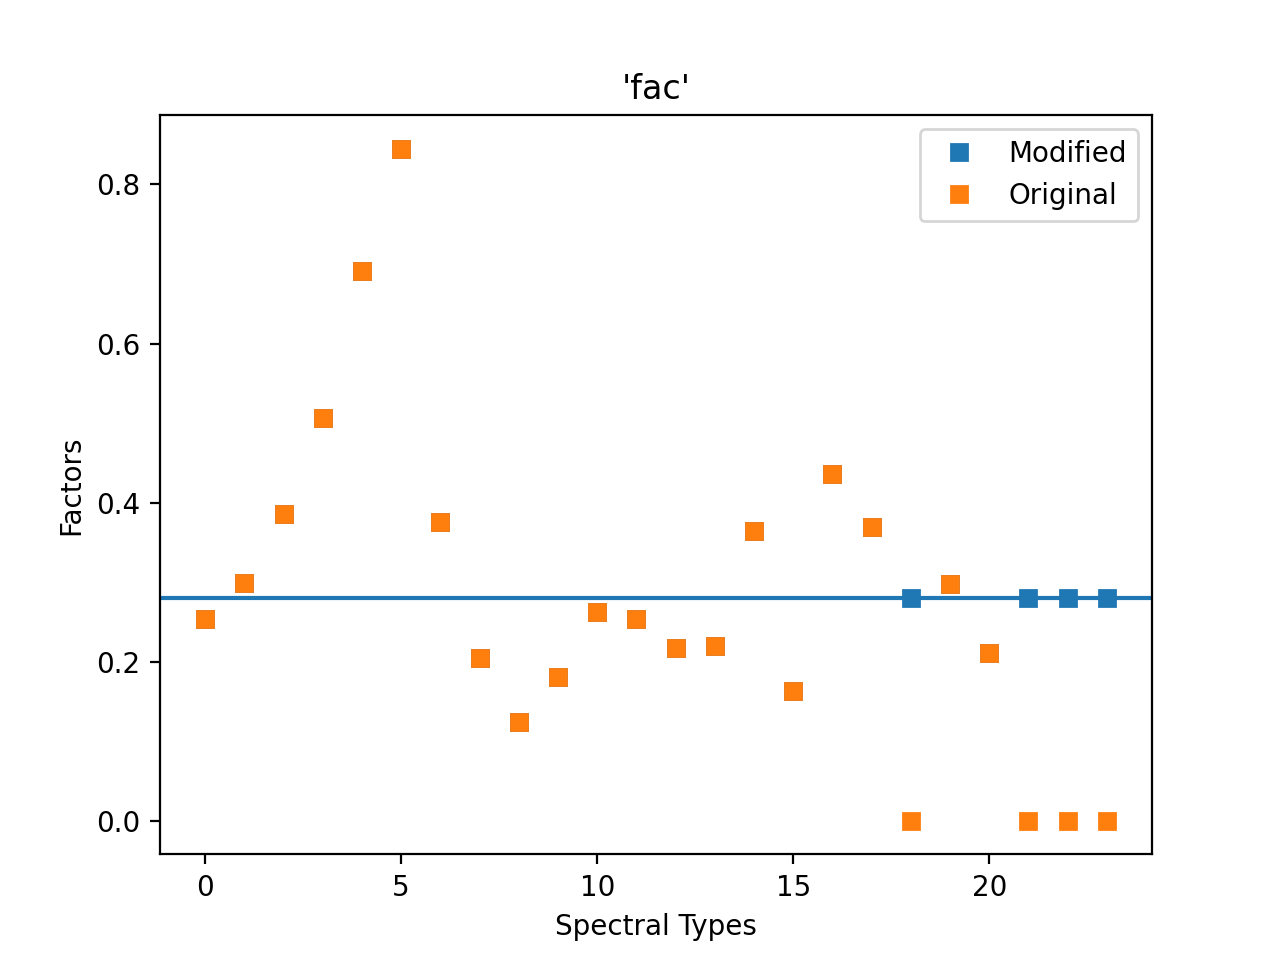

In [109]:
# Calculate the median of all non-zero 'fac', 'mdn'
mdn=np.median([fac[typ] for typ in fac if fac[typ]!=0])

# Security Control
try:std['None']
except:

    # Define the new 'std' dict as a copy of the one from the cell above
    # But replace an entry with median('fac')*typ when std(lmb)==0   
    # Note that instead of cheking if all values in std(lmb) are zero, we simply check if fac[typ]==0
    std={typ:std[typ]if fac[typ]!=0 else mdn*bas[typ]for typ in std}
    
    # Define an empty star ☆ with no flux and no 'std'
    std['None']=np.zeros_like(std['K7'])
    bas['None']=np.zeros_like(bas['K7'])
    # This will come in handy later for ★ + ☆ = ★
    # i.e. a binary integrated by a star ★ and an empty star ☆ will simply return the original ★

# Plots
fig,ax=plt.subplots()
#y=[mdn+len(dic[typ])/350 for typ in dic if dic[typ]]
#plt.plot(np.arange(len(y)),y,label='$\propto $no. of sources',color='grey',zorder=0,alpha=.5)
plt.plot(range(len(fac)),[fac[typ]if fac[typ]!=0 else mdn for typ in fac],'s',label='Modified')
plt.plot(range(len(fac)),fac.values(),'s',label='Original')
plt.axhline(mdn)
plt.xlabel(r'Spectral Types')
plt.ylabel('Factors')
plt.title("'fac'")
plt.legend()
plt.show()


# Modelos y sus desviaciones

Un modelo de binaria será la suma de los flujos de las dos estrellas que lo integren.

In [54]:
# En bin_sed guardaré los modelos
bin_sed={}

# En bin_std guardaré sus std(lmb)
bin_std={}

# Para cada tipo espectral de la primaria
for i in std:
    if i!='None':
        bin_sed[i],bin_std[i]={},{}

        # Para cada tipo espectral de la compañera
        for j in std:

            # Evito combinaciones repetidas
            if j==i or j not in bin_sed:

                # Calculo modelo de binaria como suma de flujos
                bin_sed[i][j]=bas[i]+bas[j] 

                # Calculo su desviacion estandar como la suma en cuadratura de la std de cada modelo
                bin_std[i][j]=np.sqrt(np.square(std[i])+np.square(std[j]))


# Luminosity Function

<IPython.core.display.Javascript object>


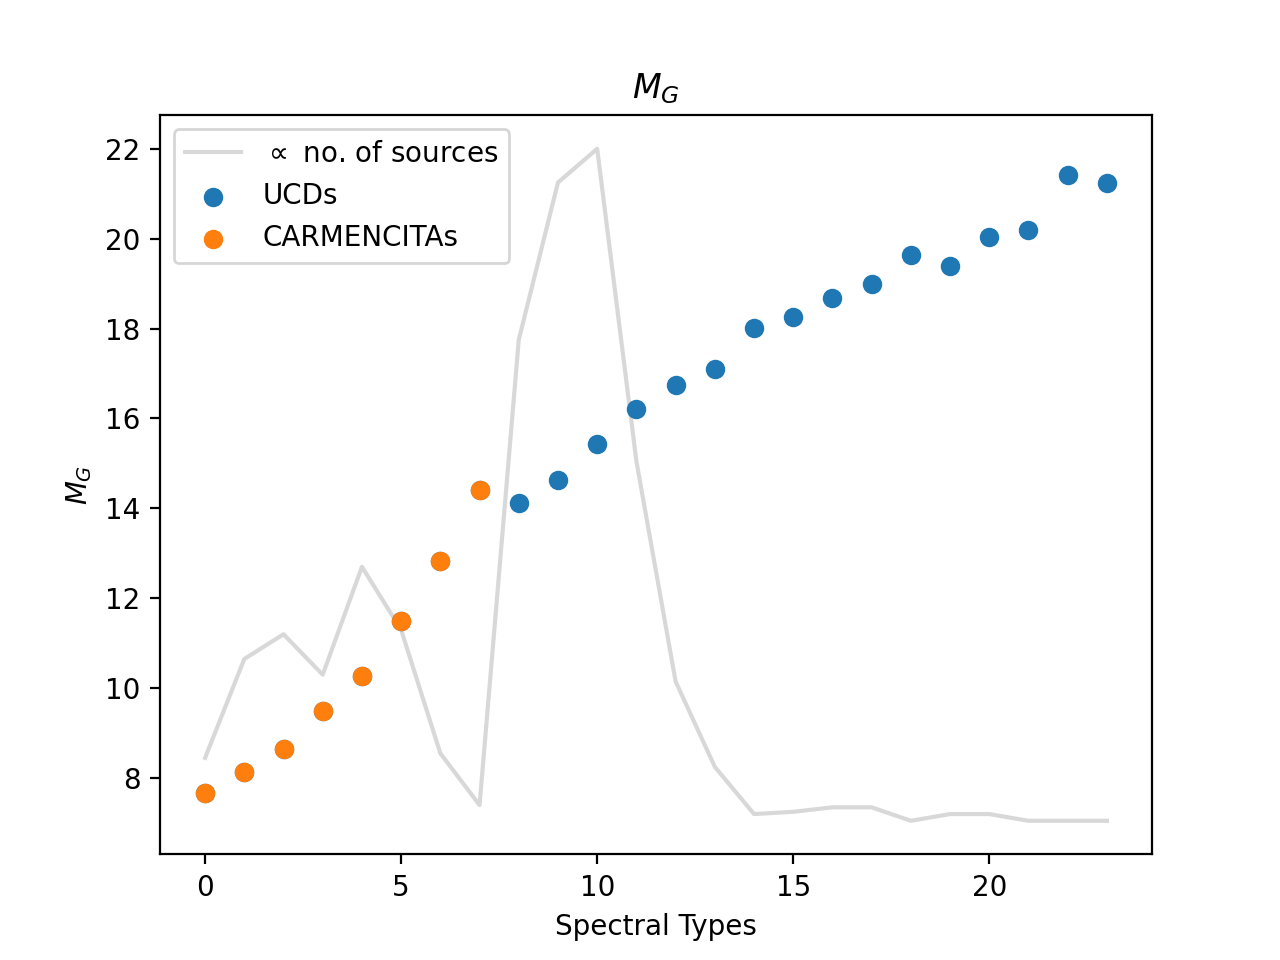

<IPython.core.display.Javascript object>


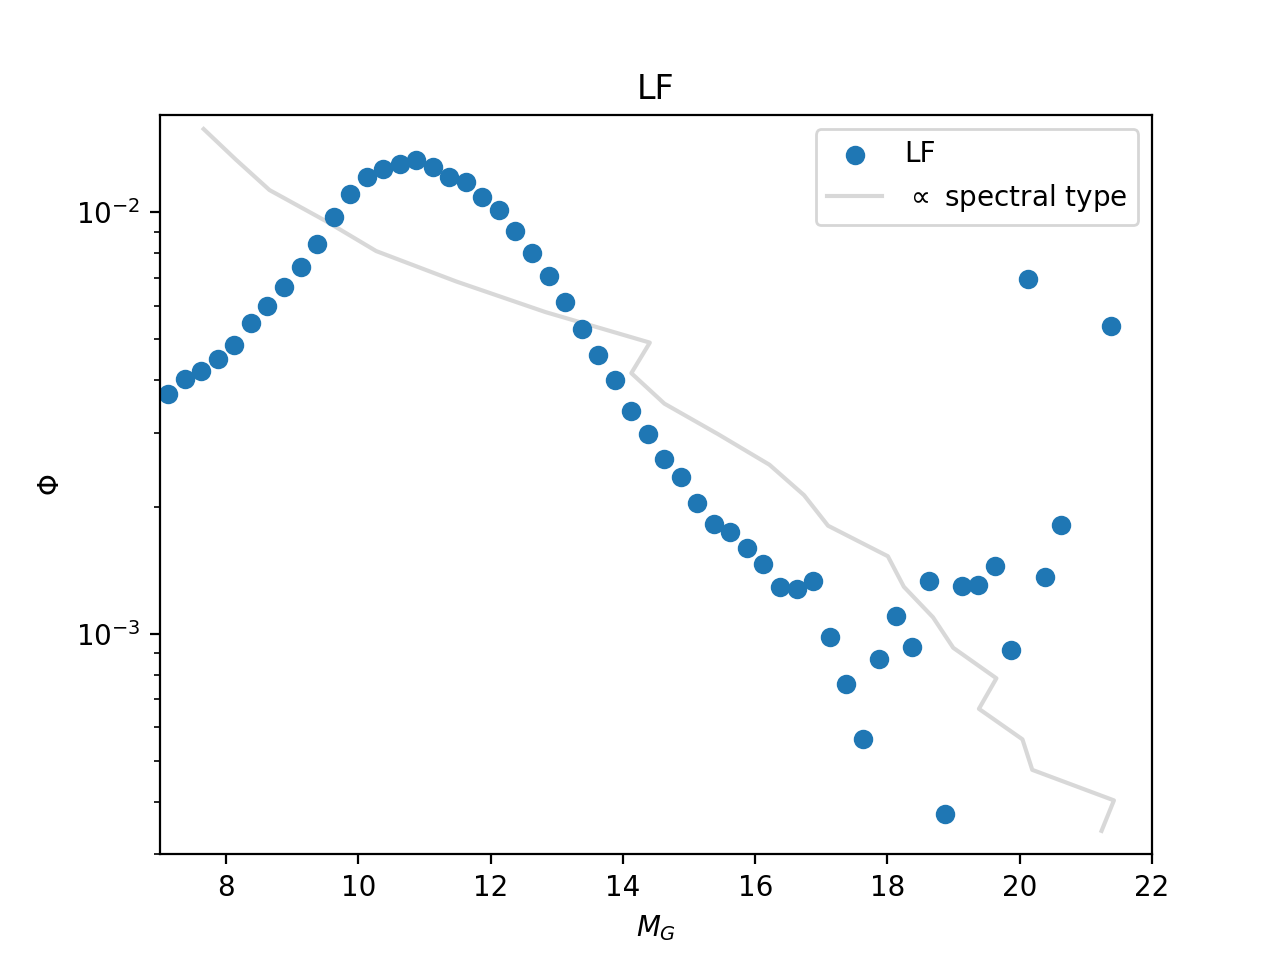

In [159]:
y=[7+len(dic[typ])/20 for typ in dic if dic[typ]]
plt.plot(np.arange(len(y)),y,label='$\propto$ no. of sources',color='grey',zorder=0,alpha=.3)
y=[np.median([dr3['gmm'][itm]-10+5*log(dr3['par'][itm])for itm in dic[typ]])for typ in dic if dic[typ]]
plt.scatter(np.arange(len(y)),y,label='UCDs')
z=[np.median([dr3['gmm'][itm]-10+5*log(dr3['par'][itm])for itm in dic[typ]])for typ in('K7','M0','M1','M2','M3','M4','M5','M6')]
plt.scatter(np.arange(len(z)),z,label='CARMENCITAs')
plt.xlabel('Spectral Types');plt.ylabel('$M_G$');plt.title('$M_G$')
plt.legend();plt.show()
l_f=pd.read_csv('lf.csv')
plt.scatter(l_f['Mg'],l_f['PhiMgpc3'],label='LF')
plt.plot(y,np.e**(-np.arange(len(y))/6-4.15),label='$\propto$ spectral type',color='grey',zorder=0,alpha=.3)
plt.yscale('log')
plt.xlim(7,22);plt.ylim(3e-4,17e-3)
plt.xlabel('$M_G$');plt.ylabel('$\Phi$');plt.title('LF')
plt.legend();plt.show()

In [76]:
# Primera aproximación de la Luminosity Function        
luf={}
luf['K7']=0.004
luf['M0']=0.004
luf['M1']=0.005
luf['M2']=0.008
luf['M3']=0.010
luf['M4']=0.008
luf['M5']=0.005
luf['M6']=0.003
luf['M7']=0.003
luf['M8']=0.002
luf['M9']=0.001
luf['L0']=0.001
luf['L1']=0.001
luf['L2']=0.001
luf['L3']=0.001
luf['L4']=0.001
luf['L5']=0.001
luf['L6']=0.001
luf['L7']=0.001
luf['L8']=0.001
luf['L9']=0.001
luf['T0']=0.001
luf['T2']=0.001
luf['T5']=0.001
luf['None']=1

# Factor de normalización para modelos individuales
c4s=sum(luf.values())-1

# Factor de normalización para modelos de binarias
c4b=0
for i in bin_std:
    for j in bin_std[i]:
        if j!='None':
            c4b+=luf[i]*luf[j]

# Análisis

In [86]:
# Analizar un RP dado su DR3 ID
def ana(id_):
    z=0
    if True:#dr3['ruw'][id_]>2:

        # Leo el espectro
        spe=spe_55[id_]

        # Leo la paralaje
        par=dr3['par'][id_]

        # Corrijo el flujo en distancia
        flx=spe*1e4/par**2

        # Leo el error en el espectro
        flx_err=err_55[id_]

        # Leo el error en la paralaje
        par_err=dr3['par_err'][id_]

        # Error en el flujo corregido en distancia
        flx_err=np.abs(flx_err*1e4/par**2)+np.abs(par_err*spe*2e4/par**3)

        # Voy a calcular evidencias
        evi={}
        
        # También calcularé distancias (dis) a elementos individuales escalados por un factor (fcs)
        fcs,dis={},{}

        # Para cada modelo
        for i in bin_std:
            if i!='None':
                for j in bin_std[i]:
                    
                        #
                        # Problema de mínimos cuadrados para el cálculo de factores de escala
                        #
                        
                        if True:
                            x=cp.Variable()
                            pro=cp.Problem(cp.Minimize(cp.sum_squares(bas[i]*x-flx)),[x<=10,x>=.1])
                            try:pro.solve()
                            except:pass
                            else:
                                if x.value is not None and x.value<10 and x.value>.1:fcs[i],dis[i]=x.value,pro.value

                                
                        #
                        # Método del factor de Bayes a continuación
                        #
                                
                        # Aproximo el prior como producto del valor de la LF para cada tipo espectral
                        pri=luf[i]*luf[j]
                        if j=='None':pri=pri/c4s
                        else:        pri=pri/c4b

                        # La std es la suma en cuadratura del error en el flujo y la std del modelo
                        std=np.sqrt(np.square(bin_std[i][j])+np.square(flx_err))

                        # Las verosimilitudes responden a una distribución gausiana en torno al modelo
                        ver=np.e**(-0.5*np.square((flx-bin_sed[i][j])/std)-ln(std))

                        # Productorio de verosimilitudes
                        ver=np.prod(ver)

                        # Probabilidad Conjunta. Evidencia es veosimilitud por prior
                        evi_mod=ver*pri

                        # Guardo el resultado
                        evi[(i,j)]=evi_mod

        # Marginalizar. Factor de Bayes fac = m_b / m_i
        m_b,m_i=0,0
        for val in evi:
            if val[1]=='None':m_i+=evi[val]
            else:m_b+=evi[val]
        fac=m_b/m_i
        

        
        #
        # Representación del resultado
        #
        
        if True:
            try:k=min(dis, key=lambda k: dis[k])
            except:dis=False
            else:dis=True
            i,j=max(evi, key=lambda k: evi[k])
            dis_bay=np.sqrt(np.sum(np.square((flx-bin_sed[i][j]))))
            if fac>100:#dis and not i==j=='K7'and fac>100 and dis_bay*1.1<np.sqrt(bst_sin):
                if True:
                    fig,ax=plt.subplots()
                    ax.plot(xax,bin_sed[i][j],color='#00c6ff',label='Modelo '+i+'+'+j)
                    ax.plot(xax,flx,color='#6000c2',label='Espectro a 10 pc',marker='D',markersize=3.5, linestyle='')
                    plt.legend()
                    plt.xlabel(r'Pseudo- Longitud de Onda $\Lambda$ [PDU]');plt.ylabel(r'Flujo a 10 pc [e$^-$/s]')
                    ax.set_title('Gaia DR3 ID: '+str(id_))
                    formatter = FuncFormatter(scientific_notation)
                    ax.yaxis.set_major_formatter(formatter)
                    ax.text(.03,.6,'ruwe = '+format(dr3['ruw'][id_], ".3f")+'\n K = '+str(int(fac)),transform=ax.transAxes,bbox=dict(boxstyle='round',facecolor='white'))
                    plt.show()
                if True:
                    fig,ax=plt.subplots()
                    ax.plot(xax,bin_sed[i][j],color='#ff9600',label='Sistema '+i+'+'+j)
                    if i!=j:ax.plot(xax,bas[i],color='#ff9600', linestyle='--',zorder=0,label='Componentes del sist.')
                    else:ax.plot(xax,bas[i],color='#ff9600', linestyle='--',label=i,zorder=0)
                    ax.plot(xax,bas[j],color='#ff9600', linestyle='--',zorder=0)
                    ax.plot(xax,bas[k]*fcs[k],color='#00aaff',label=r'$\gamma\cdot$'+k+' ('+k+' escalada)')
                    if k not in(i,j):ax.plot(xax,bas[k],color='#00aaff',linestyle='--',label=k)
                    s_t=['K7','M0','M1','M2','M3','M4','M5','M6','M7','M8','M9','L0','L1','L2','L3','L4','L5','L6','L7','L8','L9','T0','T2','T5']
                    k=s_t.index(k)
                    if k==0:k=1
                    elif k==len(s_t)-1:k=len(s_t)-2
                    else:k=min([k+1,k-1],key=lambda k:fcs[s_t[k]])
                    k=s_t[k]
                    ax.plot(xax,bas[k]*fcs[k],color='#8000ff',label=r'$\gamma\cdot$'+k+' ('+k+' escalada)')
                    if k not in(i,j):ax.plot(xax,bas[k],color='#8000ff',linestyle='--',label=k,zorder=0)
                    ax.plot(xax,flx,color='#00e360',label='DR3 RP a 10 pc')
                    plt.legend()
                    plt.xlabel(r'Pseudo- Longitud de Onda $\Lambda$ [PDU]');plt.ylabel(r'Flujo a 10 pc [e$^-$/s]')
                    ax.set_title('Gaia DR3 ID: '+str(id_))
                    formatter = FuncFormatter(scientific_notation)
                    ax.yaxis.set_major_formatter(formatter)
                    ax.text(.03,.4,'ruwe = '+format(dr3['ruw'][id_], ".3f")+'\n K = '+str(int(fac)),transform=ax.transAxes,bbox=dict(boxstyle='round',facecolor='white'))
                    plt.show()
                z=1
    return fac

# Un buen ejemplo

<IPython.core.display.Javascript object>


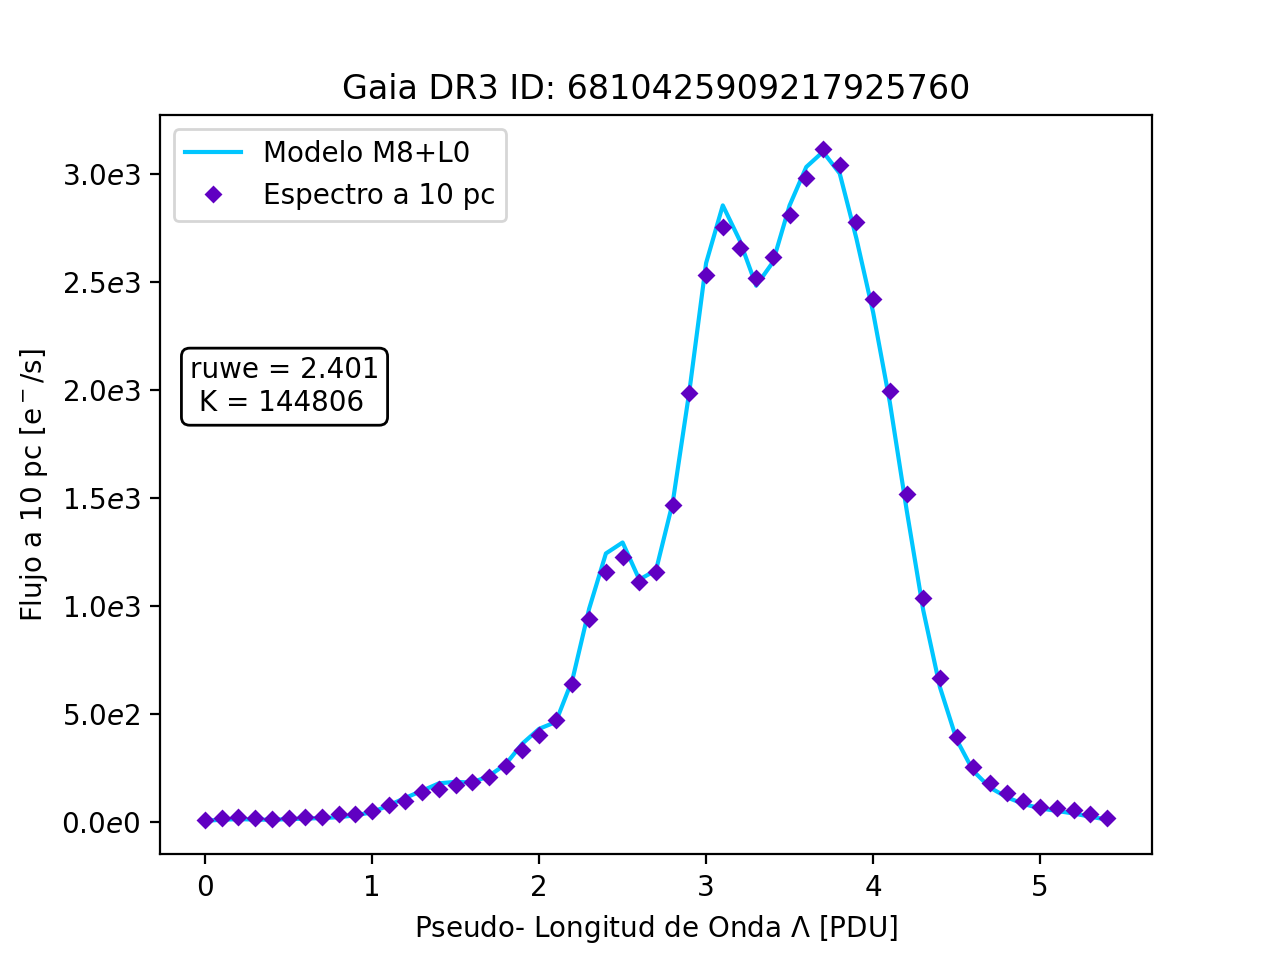

<IPython.core.display.Javascript object>


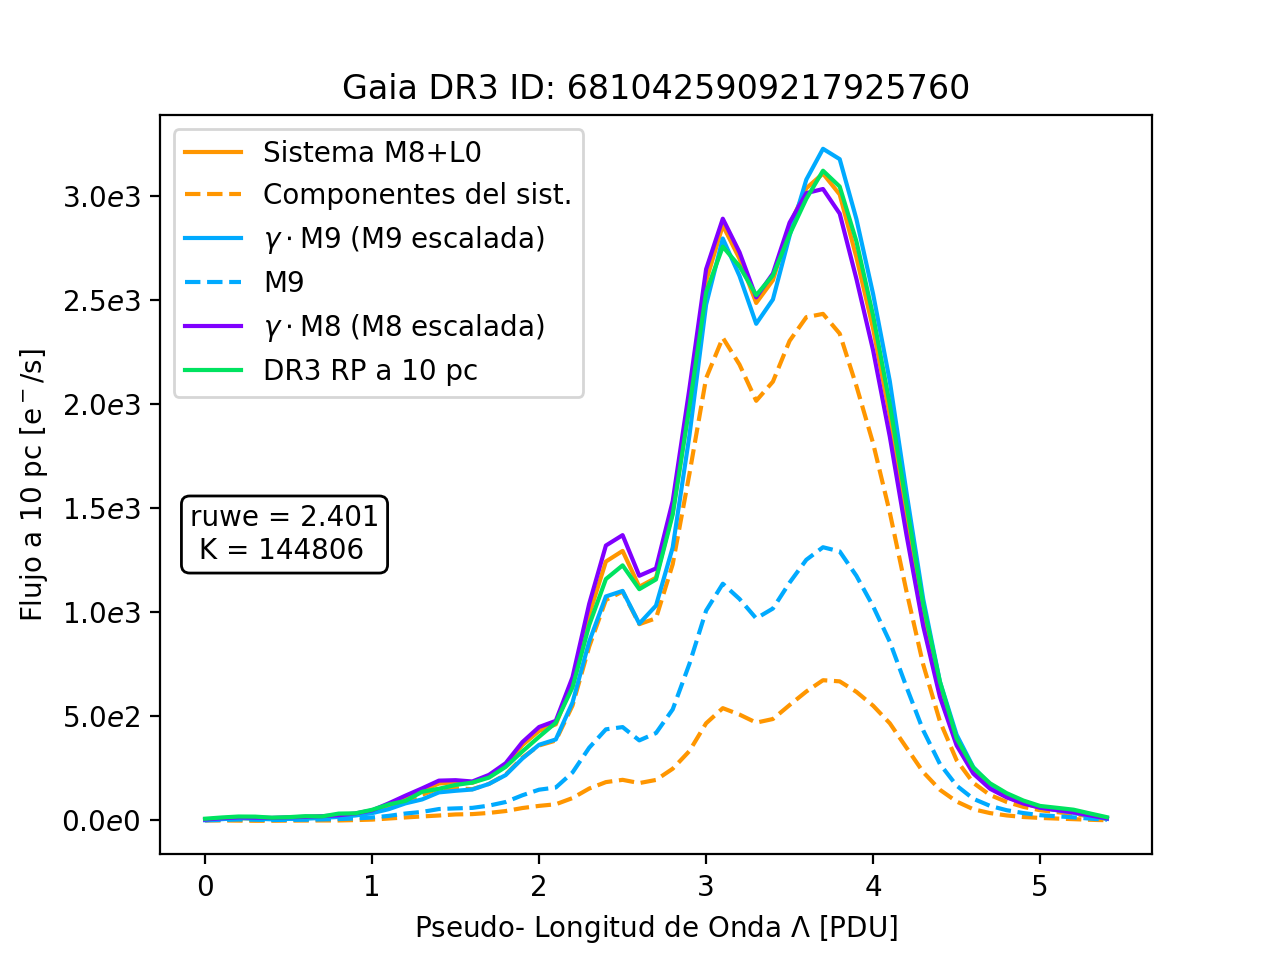

144806.9995552723

In [87]:
ana(6810425909217925760)

# Histograma del Factor de Bayes

In [84]:
fac=[]
for id_ in dr3['grp'].keys():
    try:fac.append(ana(id_))
    except:pass

/var/folders/tk/841xpcx10_jf42z5njdqfjkm0000gn/T/ipykernel_40451/3625089147.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  fac=m_b/m_i
/var/folders/tk/841xpcx10_jf42z5njdqfjkm0000gn/T/ipykernel_40451/3625089147.py:77: RuntimeWarning: invalid value encountered in scalar divide
  fac=m_b/m_i
/var/folders/tk/841xpcx10_jf42z5njdqfjkm0000gn/T/ipykernel_40451/3625089147.py:61: RuntimeWarning: divide by zero encountered in log
  ver=np.e**(-0.5*np.square((flx-bin_sed[i][j])/std)-ln(std))


<IPython.core.display.Javascript object>


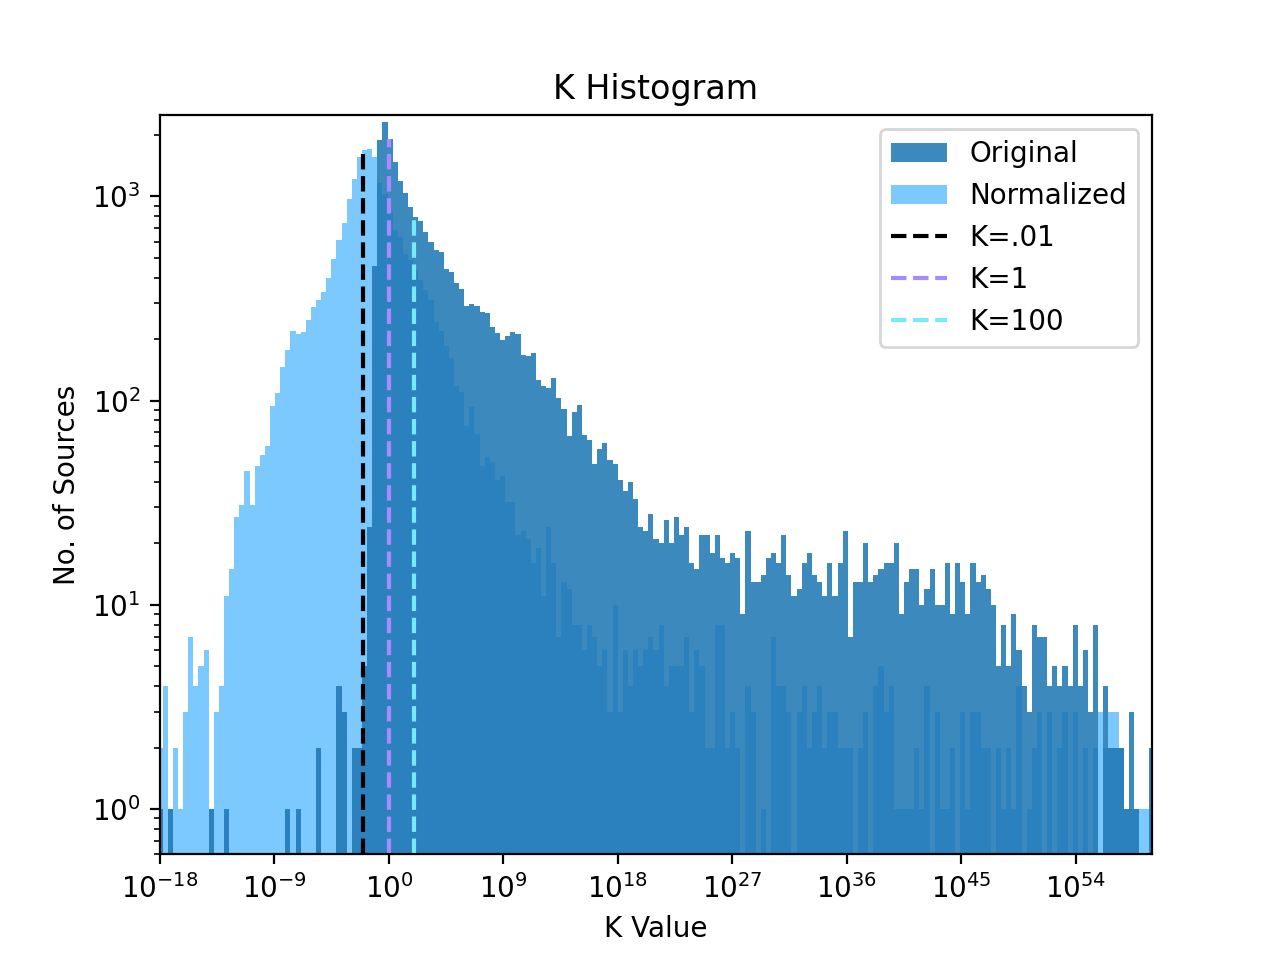

In [85]:
with open('fac_nor.pickle','rb')as f:nor=pickle.load(f)
n,bins,patches=plt.hist([x for x in fac if x!=np.inf],bins=np.logspace(-19,61,200),label='Original',alpha=.87)
m,bims,patches=plt.hist([x for x in nor if x!=np.inf],bins=np.logspace(-19,61,200),label='Normalized',color='#7bc9ff',zorder=0)
plt.plot([.01,.01],[.6,m[np.abs(bims-.01).argmin()]],color='black',linestyle='--',label='K=.01')
plt.plot([1,1],[.6,n[np.abs(bins-1).argmin()]],color='#a68bff',linestyle='--',label='K=1')
plt.plot([100,100],[.6,n[np.abs(bins-100).argmin()]],color='#76eaff',linestyle='--',label='K=100')
plt.xscale('log');plt.yscale('log')
plt.xlim(1e-18,1e60)
plt.ylim(.6,2.5e3)
plt.xlabel('K Value')
plt.ylabel('No. of Sources')
plt.title('K Histogram')
plt.legend()
plt.show()
